# SVM for Text Data

## Introduction of SVM

Support vector machine is an algorithm set that can do regression and classification prediction. The output of the algorithm is a classification hyperplane. According to different input characteristics, different kernel functions, namely different hyperplane shapes, can be selected for classification.


For the classified model, SVM uses hard classification and soft classification. Hard classification is to train the classifier in a completely accurate way, which is reflected in that the constraint conditions are either black or white. Soft classification is another way by introducing a parameter  to partly accept a few incorrectly classified points to tackle the cases that the points cannot be rigorously classified.


For the loss function, Support Vector Machine maximizes the distance of all points from the classification hyperplane, and uses dual algorithm and KKT algorithm to optimize, to calculate the parameters of the hyperplane. In the process of prediction, support vector machine uses symbolic functions to classify points according to their positions relative to the hyperplane.

## Preparations

**import python packages and read data from csv file**

In [4]:
import matplotlib.pyplot as plt
import nltk
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [5]:
df=pd.read_csv('free_mtr_text_data.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
textdata=df["text"].to_list()

print("number of text chunks = ",len(textdata))
print(textdata[0:3])

(4448, 2)
index = 0 : label = freeway
index = 1 : label = metro
number of text chunks =  4448
['woman accused killing mother wednesday morning reportedly called police confess officer found http co groxls9foq', 'people think taking train poor people train exciting part every commut http co 2uues0mrn4', 'natural history museum los angeles county 1975 2003 halona susanna harrison mercedes ca2wwr379 rosa park http co piorjpzjcd']


This is the text data originated from the twitter API. The label of this data has two catagories: "freeway" and "metro". The goal of this SVM model is learn to recognize the right catagory (freeway or metro) from a single piece of text data. This data has already been cleaned.

First, let's see the distribution of two labels:

In [6]:
print("label=freeway(0): ",Counter(y1)[0])
print("label=metro(1): ",Counter(y1)[1])

label=freeway(0):  2502
label=metro(1):  1946


convert this text data to onehot matrix in order for machine learning models to input

In [7]:
# INITIALIZE COUNT VECTORIZER
vectorizer=CountVectorizer(min_df=5)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
vec=vectorizer.fit_transform(textdata)   
dense=np.array(vec.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(dense,axis=0)
onehot=np.ceil(dense/maxs)

# DOUBLE CHECK 
print(onehot.shape,y1.shape)

(4448, 1712) (4448,)


## Data explorations

Following is heat map of distance matrix of first 250 variables

(250, 250)
[[0.         0.         0.         ... 0.         0.22222222 0.23570226]
 [0.         0.         0.11952286 ... 0.         0.         0.        ]
 [0.         0.11952286 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.1118034 ]
 [0.22222222 0.         0.         ... 0.         0.         0.23570226]
 [0.23570226 0.         0.         ... 0.1118034  0.23570226 0.        ]]


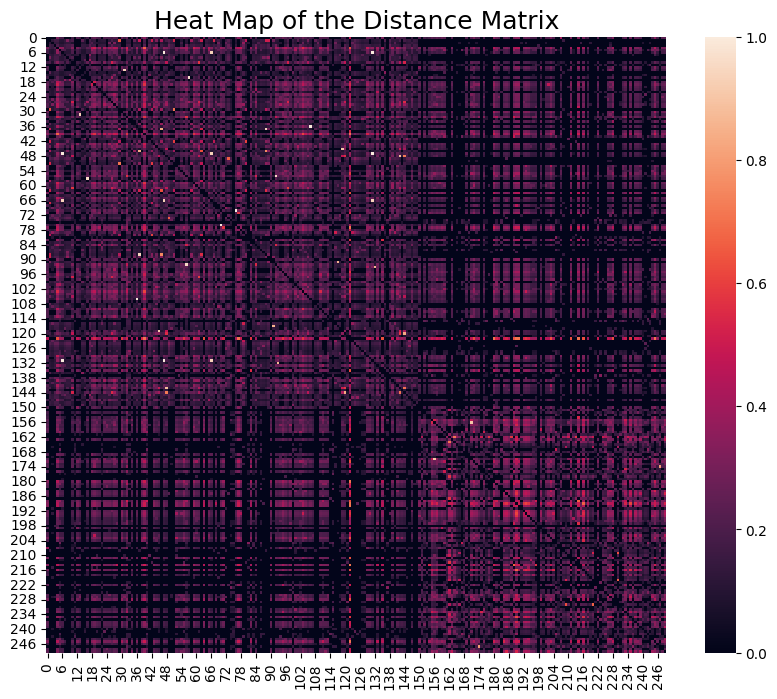

In [8]:
num_rows_keep=250
index=np.sort(np.random.choice(onehot.shape[0], num_rows_keep, replace=False))
tmp1=onehot[index, :]

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) 
        
        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2)
        
dij=np.array(dij)

import seaborn as sns
fig,axes = plt.subplots(1, 1, num="stars",figsize=(10, 8))
plot1=sns.heatmap(dij, annot=False)
plot1.set_title("Heat Map of the Distance Matrix", fontsize=18)
print(dij.shape)
print(dij)
plt.savefig("distance.png")

Then I use PCA and create 3D plot and pairplots to see how data in onehot matrix approximately distributed

[0.07272411 0.05176986 0.02206656 0.01963864 0.01734547 0.01327158
 0.01097582 0.00931019 0.00816361 0.00716267]
[48.8346509  41.20285902 26.90024032 25.37724952 23.84964287 20.86171974
 18.97174436 17.47302548 16.36176375 15.32591002]


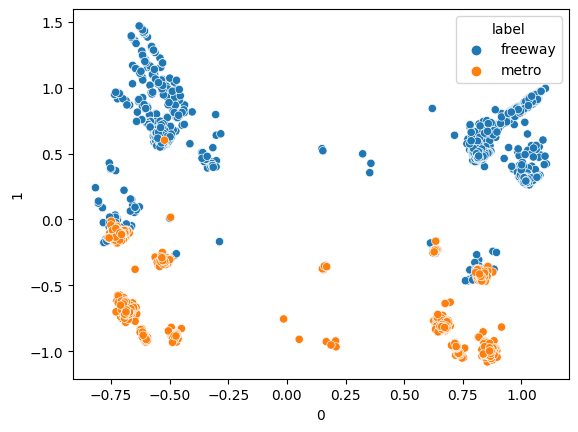

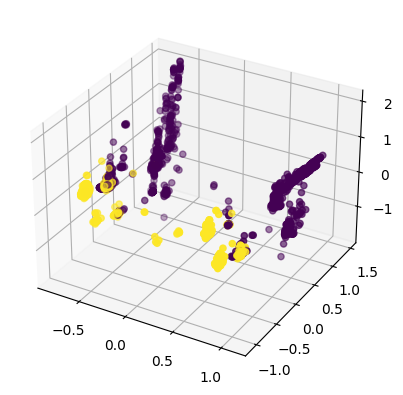

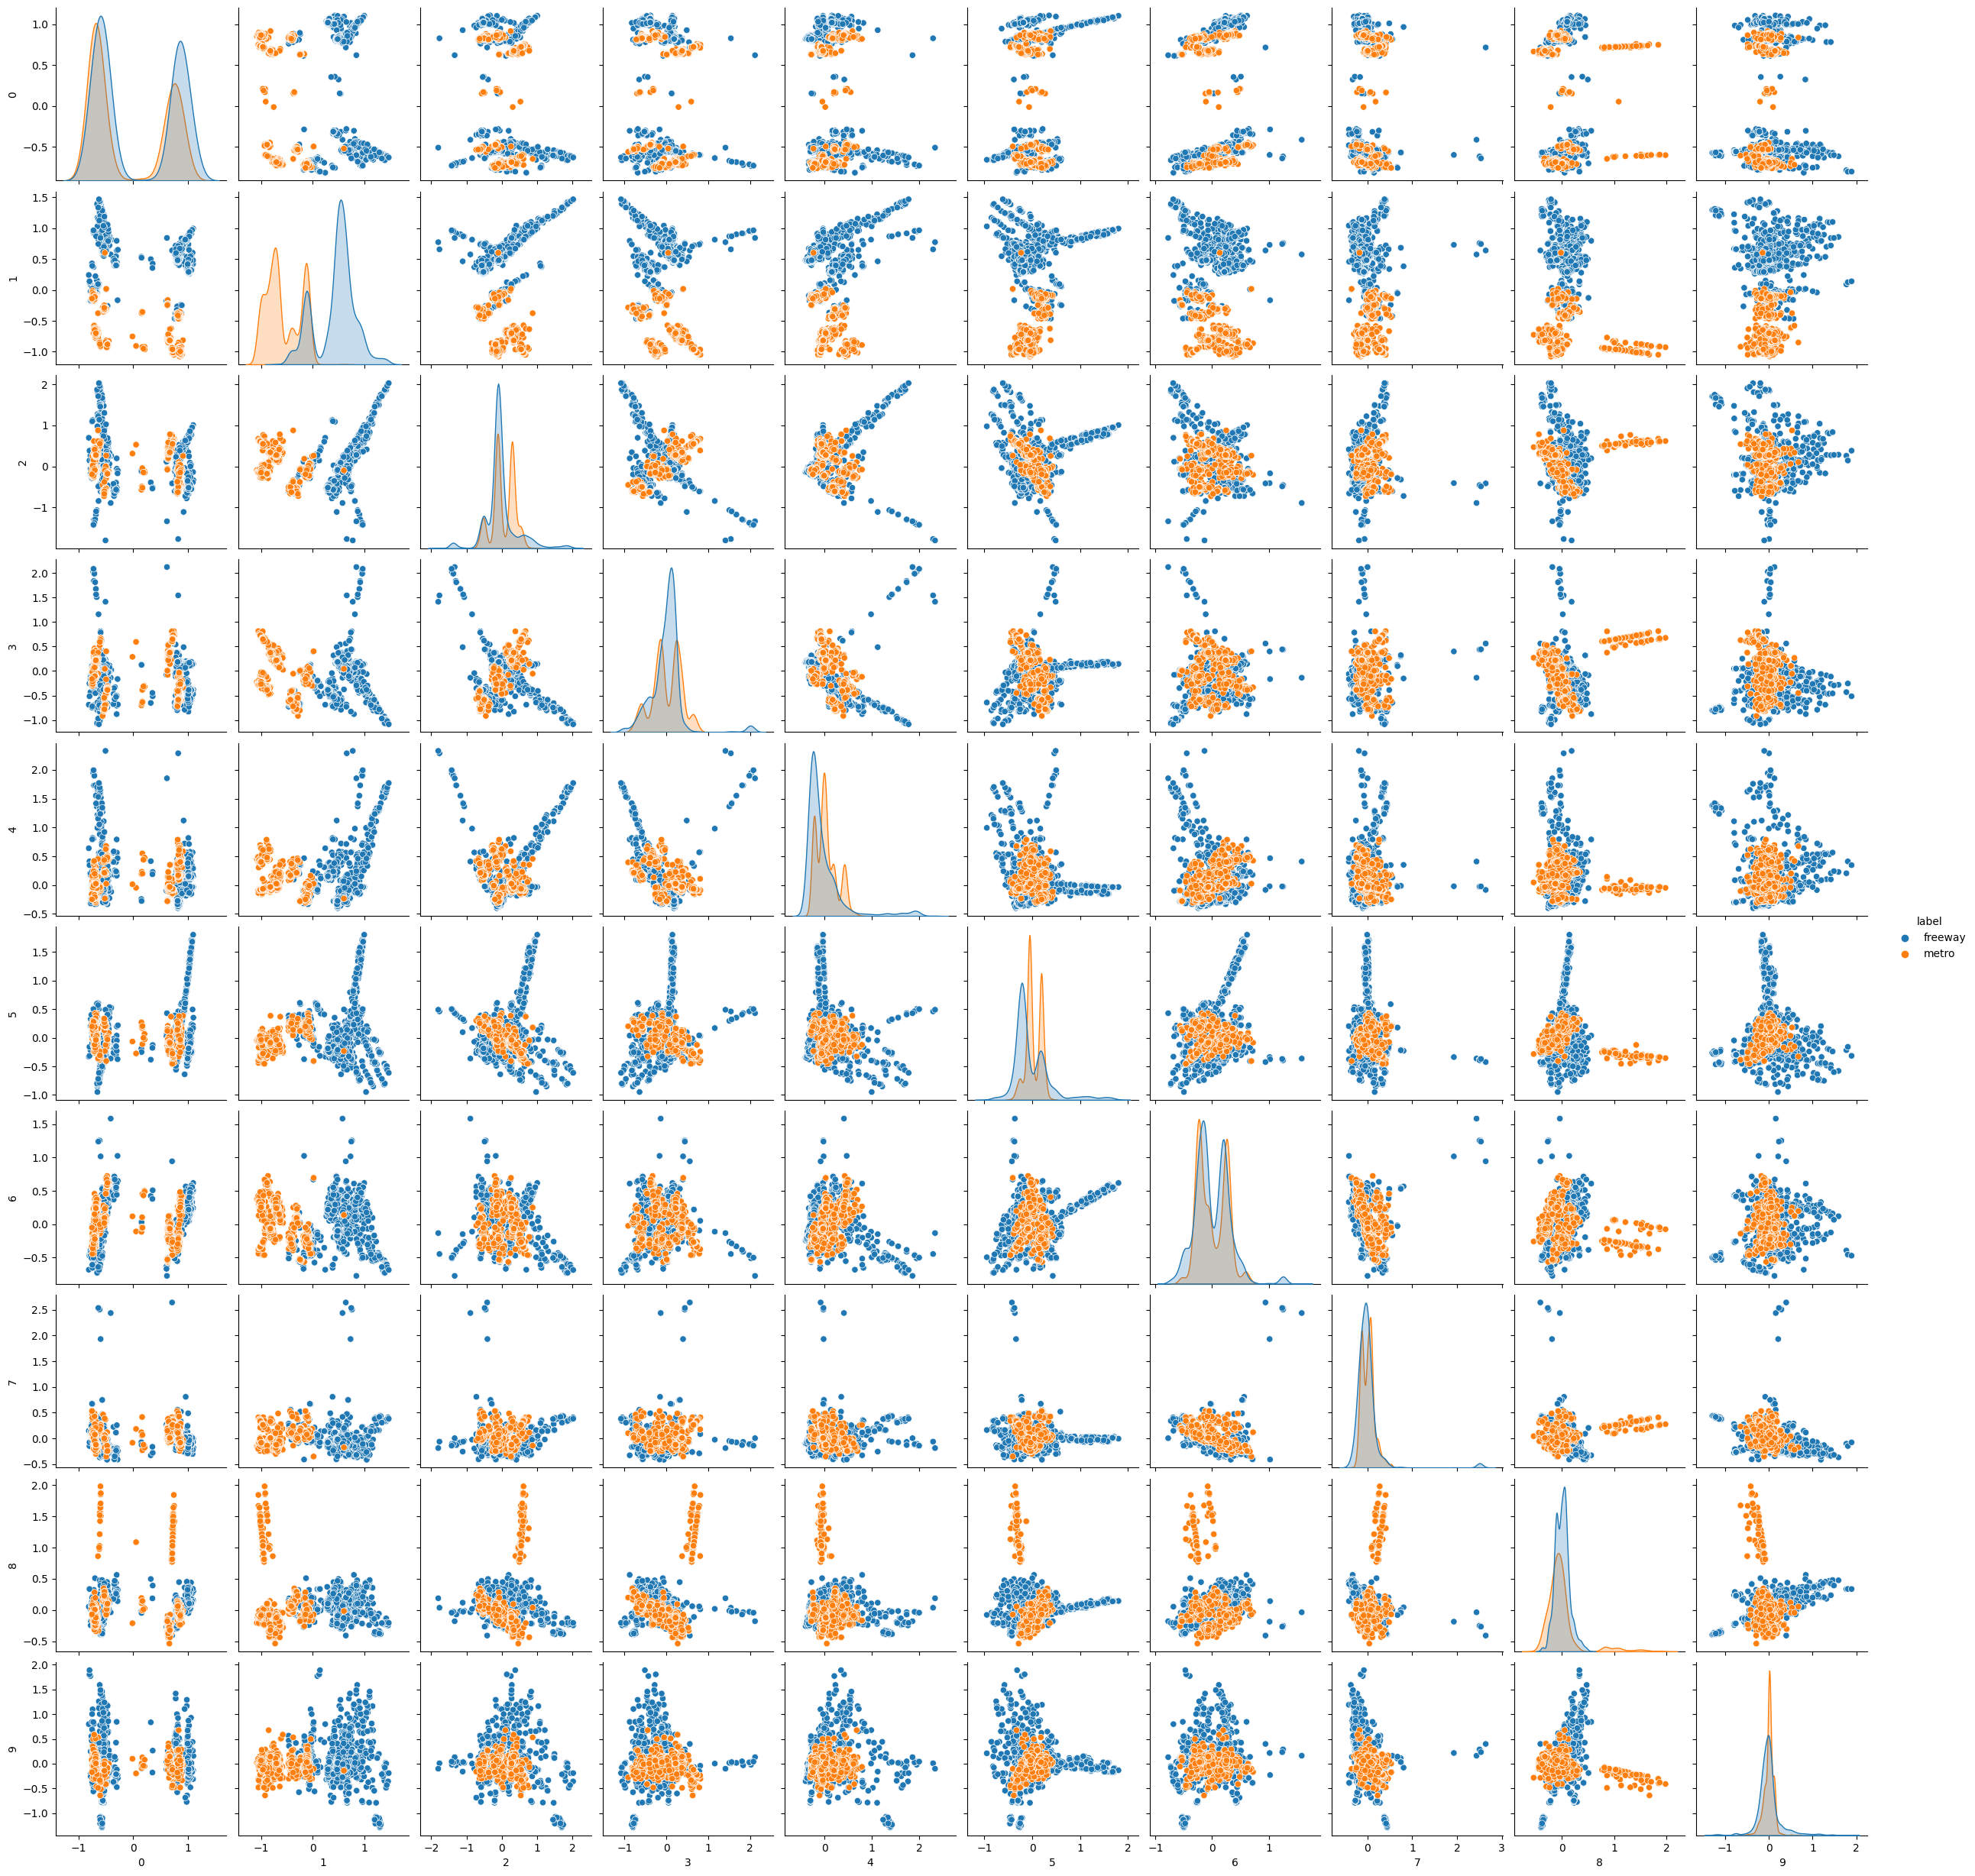

In [9]:
from sklearn.decomposition import PCA

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(onehot)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(onehot)
df2 = pd.DataFrame(data = principal_components) 
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
plot2=sns.pairplot(data=df3,hue="label") 
#plt.show()
plt.savefig("pairplot.png")

From these plots, we can find that the data belongs to "freeway" and data belongs to "metro" can be roughly seperated by a hyperplane.

## Data modeling

Now I split the data into train data set and test data set where the ratio of test data is 0.2

In [10]:
#split to train data and test data

from sklearn.model_selection import train_test_split
X=onehot
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("x_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (3558, 1712)
y_train.shape		: (3558,)
x_test.shape		: (890, 1712)
y_test.shape		: (890,)


Since the onehot matrix is acctually a sparse matrix, the mean of each columns is close to 0. Thus, there's no need to nomalize this data.

In [11]:
np.mean(x_train.std(axis=0))

0.05568728162523648

Now I use SVM model to fit the train data set and I choose "Linear" kernel.

In [12]:
model = SVC(C=0.5, kernel='linear')
model.fit(x_train, y_train)

SVC(C=0.5, kernel='linear')

In [13]:
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

In [14]:
# Calculate the confusion matrix and classification report for the train and test data. 
con_matrix_train = confusion_matrix(y_train,yp_train,labels=model.classes_)
print("train:")
print(con_matrix_train)
print("----------------------------")
con_matrix_test = confusion_matrix(y_test,yp_test,labels=model.classes_)
print("test:")
print(con_matrix_test)

train:
[[1948   31]
 [   7 1572]]
----------------------------
test:
[[486  37]
 [ 25 342]]


## Model tuning

From the results, we can see that SVM model perform well on this data. Next, I will try other different kernels to find whether the accuracy of SVM model can be further improved.

In [15]:
def svm_acc(x_train,y_train,x_test,y_test,kernel):
    model = SVC(C=0.5, kernel=kernel)
    model.fit(x_train, y_train)
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    train_report = classification_report(y_train,yp_train,output_dict = True)
    test_report = classification_report(y_test,yp_test,output_dict = True)
    train_report_df = pd.DataFrame.from_dict(train_report).T
    test_report_df = pd.DataFrame.from_dict(test_report).T
    train_acc=train_report_df.loc["accuracy","precision"]
    test_acc=test_report_df.loc["accuracy","precision"]
    return train_acc,test_acc

I will test linear kernel, polynomial kernel, rbf kernel and sigmoid kernel successively as follows.

In [16]:
kernel_list=["linear","poly","rbf","sigmoid"]

In [17]:
train_accs=[]
test_accs=[]
for k in kernel_list:
    train_acc,test_acc=svm_acc(x_train,y_train,x_test,y_test,k)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

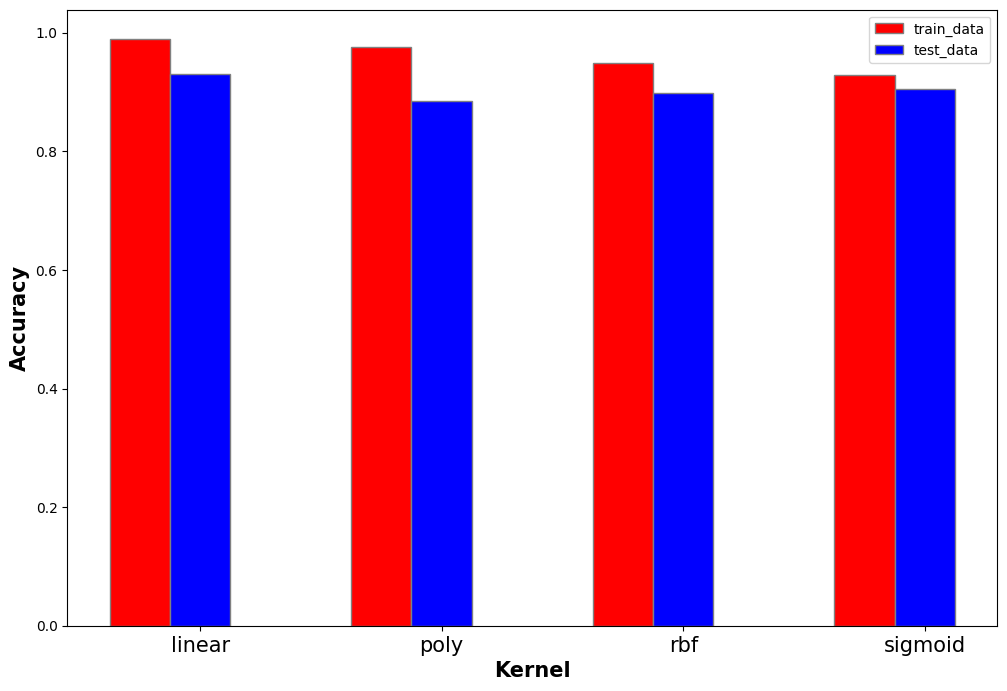

In [18]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(train_accs))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, train_accs, color ='r', width = barWidth,
        edgecolor ='grey', label ='train_data')
plt.bar(br2, test_accs, color ='b', width = barWidth,
        edgecolor ='grey', label ='test_data')
 
# Adding Xticks
plt.xlabel('Kernel', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_accs))],
        ['linear', 'poly', 'rbf', 'sigmoid'],fontsize=15)
 
plt.legend()
plt.show()

According to this graph above, we can see that linear kernel have best accuracy on both train data and test data. Therefore, I choose linear kernel as the final hyperparameter.

## Baseline comparison

Additionally, let's compare our model's result with baseline model(random classifier):

In [19]:
def generate_label_data(class_labels, weights,N=10000):
    #e.g. class_labels=[0,1]  weights=[0.2,0.8] (should sum to one)

    y=random.choices(class_labels, weights = weights, k = N)
    return y

In [20]:
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

y=generate_label_data([0,1],[0.56,0.44],10000)
random_classifier(y)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([4972, 5028])
probability of prediction: [0.4972 0.5028]
accuracy 0.507
percision, recall, fscore, (array([0.57220434, 0.44252188]), array([0.50371813, 0.51125919]), array([0.53578154, 0.47441365]), array([5648, 4352]))


There's no doubt that our SVM model(whose accuracy is greater than 0.9) have much better performance than random classifier(whose accuracy is close to 0.5).

## Final result and conclusion

In [21]:
model = SVC(C=0.5, kernel='linear')
model.fit(x_train, y_train)
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)
con_matrix_train = confusion_matrix(y_train,yp_train,labels=model.classes_)
con_matrix_test = confusion_matrix(y_test,yp_test,labels=model.classes_)

In [22]:
train_report = classification_report(y_train,yp_train,output_dict = True)
test_report = classification_report(y_test,yp_test,output_dict = True)

# Save the results in a data frame. 
train_report_df = pd.DataFrame.from_dict(train_report).T
test_report_df = pd.DataFrame.from_dict(test_report).T

print("train_report:")
print(train_report_df)
print("test_report:")
print(test_report_df)

train_report:
              precision    recall  f1-score     support
0              0.996419  0.984336  0.990341  1979.00000
1              0.980661  0.995567  0.988058  1579.00000
accuracy       0.989320  0.989320  0.989320     0.98932
macro avg      0.988540  0.989951  0.989199  3558.00000
weighted avg   0.989426  0.989320  0.989328  3558.00000
test_report:
              precision    recall  f1-score     support
0              0.951076  0.929254  0.940039  523.000000
1              0.902375  0.931880  0.916890  367.000000
accuracy       0.930337  0.930337  0.930337    0.930337
macro avg      0.926725  0.930567  0.928464  890.000000
weighted avg   0.930994  0.930337  0.930493  890.000000


plot the confusion matrix of test data set:

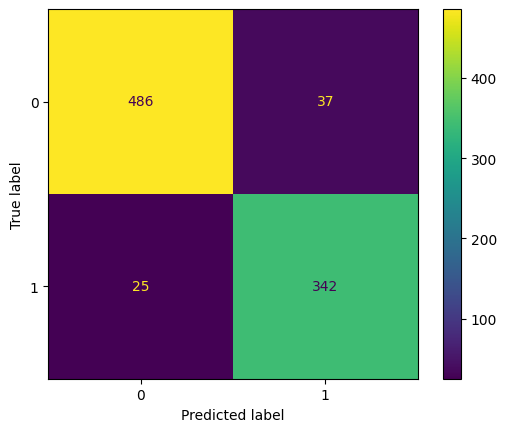

In [23]:
disp=ConfusionMatrixDisplay(confusion_matrix=con_matrix_test,display_labels=model.classes_)
disp.plot()

According to model reports above, the accuracy on test data set is over 0.93, which indicates that this SVM model perform quite well and does not overfit too much. This also means that when we give a piece of new text data to this SVM model (note that this piece of data needs to follow the distribution of the data in used above), the SVM model can recognize whether it relates to "freeway" or "metro" with a really high accuracy. 

In this data modeling process, I actually only need to consider a binary classification problem. In more complicated situation, sometimes we have to deal with those data that contains more than two catagories. For example, there might be classes like "car", "bus", "airplane" and "ship". Under this circumstance, we need to be more careful optimizing and tuning the model.